# 1. Import Libraries

In [210]:
from Historic_Crypto import HistoricalData as HD
import pandas as pd
import requests
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
# import scipy
# import textwrap
# import numpy as np
# from statistics import median, mean

# `***** DATA COLLECTION *****`

# 2. Collect Crypto Wallet Transactions Data using Etherscan API

In [211]:
def etherScanAPICall(wallet_address):
    API_KEY = 'JATAZ8XWIBGBTY15YJJEABCDPIF8SCK7S3'
    MATIC_CONTRACT_ADDRESS = '0x7D1AfA7B718fb893dB30A3aBc0Cfc608AaCfeBB0'
    # WALLET_ADDRESS = '0x9507c04b10486547584c37bcbd931b2a4fee9a41'
    url = 'https://api.etherscan.io/api?'

    parameters = {
        'module':'account',
        'action':'tokentx',
        'contractaddress':MATIC_CONTRACT_ADDRESS,
        'address':wallet_address,
        'page':'1',
        'offset':'10000',
        'startblock':'0',
        'endblock':'27025780',
        'sort':'asc',
        'apikey':API_KEY
    }

    responseJSON = requests.request("GET", url, params=parameters).json()

    print("# of Transactions:",len(responseJSON.get("result")))

    # with open("transactionsResponse.json", "w") as write_file:
    #     json.dump(responseJSON, write_file, indent=4, sort_keys = True)

    return responseJSON

In [212]:
listOfWallets = [
    '0x9507c04b10486547584c37bcbd931b2a4fee9a41',
    '0x5666ed92c83af9dab61601c87bf7769ad57103f9',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0',
    '0xed28b1c47375cd23aa6428544f4feaeaf3ee4e7b'
]

In [213]:
def etherScanAPI_MultiWallet_Call(listOfWalletAddresses):

    totalTransactionDataList = []

    for wallet in listOfWalletAddresses:
        walletTransactionData = etherScanAPICall(wallet)
        totalTransactionDataList = totalTransactionDataList + walletTransactionData.get("result")

    return totalTransactionDataList

In [214]:
rawTransactionData = etherScanAPI_MultiWallet_Call(listOfWallets)

# of Transactions: 2850
# of Transactions: 739
# of Transactions: 507
# of Transactions: 3


# 3. Create Initial Dataframe of Transaction Data

In [215]:
def createTransactionsData_df(rawTransactionData):

    # Create a DataFrame from the list of dictionaries
    rawTransactionData_df = pd.DataFrame(rawTransactionData)

    rawTransactionData_df = rawTransactionData_df.sort_values("timeStamp")
    rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

    rawTransactionData_df = rawTransactionData_df.drop('nonce', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('tokenName', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('tokenDecimal', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('input', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('confirmations', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('transactionIndex', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('blockNumber', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('hash', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('blockHash', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('gasUsed', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('cumulativeGasUsed', axis=1)
    rawTransactionData_df = rawTransactionData_df.drop('contractAddress', axis=1)

    # Print the names of all the columns in the dataframe
    # print(rawTransactionData_df.columns)

    return rawTransactionData_df

In [216]:
rawTransactionData_df = createTransactionsData_df(rawTransactionData)

# 4. Get Start and End Date from Transactions Data

In [217]:
def convert_UNIX_to_DateTime(unix):
    return datetime.utcfromtimestamp(int(unix)).strftime('%Y-%m-%d %H:%M:%S') # 

In [218]:
def getStartAndEndDate(rawTransactionData_df):
    # Get the first row of the dataframe
    startDate_UNIX = rawTransactionData_df.loc[0, "timeStamp"]
    # Get the last row of the dataframe
    endDate_UNIX = rawTransactionData_df.loc[len(rawTransactionData_df.index)-1, "timeStamp"]

    startDate = str(convert_UNIX_to_DateTime(startDate_UNIX))[0:10]
    endDate = str(convert_UNIX_to_DateTime(endDate_UNIX))[0:10]

    return startDate, endDate

In [219]:
startDate, endDate = getStartAndEndDate(rawTransactionData_df)

# 5. Collect Historical Crypto Price Data

In [220]:
def getCryptoHistoricalData(token, startDate, endDate):
    data = HD(token,86400,startDate+"-00-00",endDate+"-00-00").retrieve_data()
    # data.to_csv('tokenPriceData.csv')
    data = data.reset_index(drop=False)
    data['volume'] = data['volume'].astype(float)
    return data

In [221]:
tokenPriceData_df = getCryptoHistoricalData("MATIC-USD", startDate, endDate)

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'MATIC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2019-08-07T00:00:00
Provisional End: 2020-06-02T00:00:00
Data for chunk 1 of 5 extracted
CoinBase Pro API did not have available data for 'MATIC-USD' beginning at 2019-08-07-00-00.  
                        Trying a later date:'2019-08-07T00:00:00'
Provisional Start: 2020-06-02T00:00:00
Provisional End: 2021-03-29T00:00:00
Data for chunk 2 of 5 extracted
Provisional Start: 2021-03-29T00:00:00
Provisional End: 2022-01-23T00:00:00


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


Data for chunk 3 of 5 extracted
Provisional Start: 2022-01-23T00:00:00
Provisional End: 2022-11-19T00:00:00
Data for chunk 4 of 5 extracted
Provisional Start: 2022-11-19T00:00:00
Provisional End: 2023-09-15T00:00:00
Data for chunk 5 of 5 extracted


/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/Historic_Crypto/HistoricalData.py:176: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(dataset)


In [222]:
print(tokenPriceData_df.head())

        time     low    high    open   close       volume
0 2021-03-11  0.3140  0.5900  0.3871  0.4243  226442305.9
1 2021-03-12  0.3924  0.5376  0.4249  0.4149  399949092.9
2 2021-03-13  0.4097  0.4694  0.4146  0.4249  173058984.7
3 2021-03-14  0.3727  0.4385  0.4263  0.3812  118930211.9
4 2021-03-15  0.3781  0.4300  0.3812  0.3909  115608670.0


# `***** DATA ORGANIZATION AND MERGING *****`

# 6. Add date column to Historical Crypto Dataframe

In [223]:
def addDateColumnToTokenPriceDataframe(tokenPriceData_df):
    tokenPriceData_df.insert(1, 'date', 0)

    for index, row in tokenPriceData_df.iterrows():
        date = str(row["time"])[0:10]
        tokenPriceData_df.loc[index, "date"] = date

    tokenPriceData_df = tokenPriceData_df.drop('time', axis=1)

    return tokenPriceData_df

In [224]:
tokenPriceData_df = addDateColumnToTokenPriceDataframe(tokenPriceData_df)

# 7. Orient dates and corresponding data across Historical Crypto Data and Transactions Data

In [225]:
def orientDatesAndCorrespondingData(tokenPriceData_df, startDate, rawTransactionData_df): 
    startDate2 = str(tokenPriceData_df.loc[0, "date"]) + " 00:00:00"
    # print(startDate2)

    # Define a format string for the date and time
    date_time_fmt = "%Y-%m-%d %H:%M:%S"
    # Convert the string to a datetime object
    startDate2 = datetime.strptime(startDate2, date_time_fmt)

    # Print the datetime object
    # print(startDate2)

    # convert the datetime object into a Unix timestamp
    startDate2_UNIX = time.mktime(startDate2.timetuple())

    # print(startDate_UNIX)
    # print(startDate2_UNIX)

    startDate = str(startDate) + " 00:00:00"
    # print(startDate)
    startDate1 = datetime.strptime(startDate, date_time_fmt)
    startDate1_UNIX = time.mktime(startDate1.timetuple())

    # print(startDate, startDate1_UNIX)

    # The transactions start date is later than the crypto data start date
    if int(startDate1_UNIX) > int(startDate2_UNIX):
        startDate_main_UNIX = startDate1_UNIX

    # The transactions start date is earlier than the crypto data start date
    else:
        startDate_main_UNIX = startDate2_UNIX

    # print the Unix timestamp
    # print(startDate_main_UNIX)

    endDate = tokenPriceData_df.loc[len(tokenPriceData_df.index)-1, "date"]
    # print(endDate)

    rawTransactionData_df['timeStamp'] = rawTransactionData_df['timeStamp'].astype(float)

    rawTransactionData_df = rawTransactionData_df.drop(rawTransactionData_df.index[rawTransactionData_df.loc[:, 'timeStamp'] < startDate_main_UNIX])

    rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

    return rawTransactionData_df

In [226]:
rawTransactionData_df = orientDatesAndCorrespondingData(tokenPriceData_df, startDate, rawTransactionData_df)

# 8. Add Specified Columns to Transactions Dataframe
- date column
- buy and sell column
- value movement column
- total gas cost column

In [227]:
def addColumns_dateBuySellValueMovementTotalGasCost(rawTransactionData_df):

    # Adding data column
    rawTransactionData_df.insert(1, 'date', 0)
    for index, row in rawTransactionData_df.iterrows():
        date = convert_UNIX_to_DateTime(row["timeStamp"])[0:10]
        rawTransactionData_df.loc[index, "date"] = date

    # Adding valueMovement and tradeType columns
    rawTransactionData_df.insert(4, 'valueMovement', 0)
    rawTransactionData_df.insert(5, 'tradeType', 0)

    for index, row in rawTransactionData_df.iterrows():
        tradeType = "n/a"
        # considered a BUY
        if row["to"] in listOfWallets:
            valueMovement = int(row["value"])/(10**18)
            tradeType = "BUY"
        # considered a SELL
        elif row["from"] in listOfWallets:
            valueMovement = -1 * (int(row["value"])/(10**18))
            tradeType = "SELL"

        rawTransactionData_df.loc[index, "valueMovement"] = valueMovement
        rawTransactionData_df.loc[index, "tradeType"] = tradeType

    rawTransactionData_df = rawTransactionData_df.drop('value', axis=1)

    # Adding totalGasCost column
    rawTransactionData_df.insert(9, 'totalGasCost', 0)

    for index, row in rawTransactionData_df.iterrows():
        totalGasCost = int(row['gas']) * int(row['gasPrice'])
        rawTransactionData_df.loc[index, "totalGasCost"] = totalGasCost

    return rawTransactionData_df

In [228]:
rawTransactionData_df = addColumns_dateBuySellValueMovementTotalGasCost(rawTransactionData_df)

# 9. Typecast Data in Transactions Datafame

In [229]:
def typeCastDateIn_rawTransactionData_df(rawTransactionData_df):
    # convert the column to dataTypes
    rawTransactionData_df['date'] = rawTransactionData_df['date'].astype(str)

    rawTransactionData_df['valueMovement'] = rawTransactionData_df['valueMovement'].astype(int)

    rawTransactionData_df['gas'] = rawTransactionData_df['gas'].astype(float)

    rawTransactionData_df['gasPrice'] = rawTransactionData_df['gasPrice'].astype(float)

    rawTransactionData_df['totalGasCost'] = rawTransactionData_df['totalGasCost'].astype(int)

    return rawTransactionData_df

In [230]:
rawTransactionData_df = typeCastDateIn_rawTransactionData_df(rawTransactionData_df)

# 10. Add Specified Columns to Transactions Dataframe
- MATIC price USD column
- total cost USD column
- open-close daily column
- high-low daily column

In [231]:
def addColumns_dateBuySellValueMovementTotalGasCost(rawTransactionData_df, tokenPriceData_df):

    # Adding priceUSD column
    rawTransactionData_df.insert(7, 'priceUSD', 0)

    for index, row in rawTransactionData_df.iterrows():
        # print("ran...")
        date = rawTransactionData_df.loc[index, "date"]
        # print("date:", date)
        dateRow_df = tokenPriceData_df.loc[tokenPriceData_df['date'] == date]
        # print("dateRow:\n", dateRow_df)
        dateRow_df = dateRow_df.reset_index(drop=True)
        price = (float(dateRow_df.loc[0, "open"]) + float(dateRow_df.loc[0, "close"]))/2
        # print("price:", price)

        rawTransactionData_df.loc[index, "priceUSD"] = price

    # Adding totalCostUSD column
    rawTransactionData_df.insert(8, 'totalCostUSD', 0)

    for index, row in rawTransactionData_df.iterrows():
        totalCost = float(row["valueMovement"]) * float(row["priceUSD"])
        rawTransactionData_df.loc[index, "totalCostUSD"] = totalCost

    # Adding OCdailyPriceMovementUSD and HLdailyPriceMovementUSD scolumn
    rawTransactionData_df.insert(9, 'OCdailyPriceMovementUSD', 0)
    rawTransactionData_df.insert(10, 'HLdailyPriceMovementUSD', 0)

    for index, row in rawTransactionData_df.iterrows():

        date = rawTransactionData_df.loc[index, "date"]

        maticPrice_df = tokenPriceData_df.loc[tokenPriceData_df['date'] == date]
        maticPrice_df = maticPrice_df.reset_index(drop=True)

        open = maticPrice_df.loc[0, "open"]
        close = maticPrice_df.loc[0, "close"]
        high = maticPrice_df.loc[0, "high"]
        low = maticPrice_df.loc[0, "low"]
        
        OCprice = open - close
        HLprice = high - low

        rawTransactionData_df.loc[index, "OCdailyPriceMovementUSD"] = OCprice
        rawTransactionData_df.loc[index, "HLdailyPriceMovementUSD"] = HLprice

    rawTransactionData_df = rawTransactionData_df.sort_values("timeStamp")
    rawTransactionData_df = rawTransactionData_df.reset_index(drop=True)

    return rawTransactionData_df

In [232]:
rawTransactionData_df = addColumns_dateBuySellValueMovementTotalGasCost(rawTransactionData_df, tokenPriceData_df)

In [233]:
# Output the DataFrame to a CSV file
rawTransactionData_df.to_csv('rawTransactionData_df.csv', index=True)

# 11. Create Transactions Volume Dataframe

In [234]:
def createTransactionVolumeDF(rawTransactionData_df, tokenPriceData_df):

    datesList = tokenPriceData_df['date'].to_list()
    # print(len(datesList))
    # print(datesList[0:5])

    # Columns: -Index, #Date, *Num Transactions, *Value Movement, *Num BUYS, *Num Sells, *MATIC Price USD, -Total Cost USD, *OC daily price, *HL daily price

    dateToDailyTransactionInfoDict = {}

    for date in datesList:

        transaction_df = rawTransactionData_df.loc[rawTransactionData_df['date'] == date]
        transaction_df = transaction_df.reset_index(drop=True)

        # print("transaction_df\n", transaction_df, "\nend df...")

        if not transaction_df.empty:

            # loop through every row in the DataFrame and print the values
            for index, row in transaction_df.iterrows():

                valueMoved = row["valueMovement"]
                tradeType = row["tradeType"]

                if tradeType == "BUY":
                    buy = 1
                    sell = 0
                else: 
                    sell = 1
                    buy = 0

                if date not in dateToDailyTransactionInfoDict.keys():
                    # print('run if..')
                    dateToDailyTransactionInfoDict[date] = [1, valueMoved, buy, sell]

                # elif date in dateToDailyTransactionInfoDict.keys():
                else:
                    # print('run elif..')
                    currentTransactionInfo = dateToDailyTransactionInfoDict.get(date)

                    currentNumTransactions = int(currentTransactionInfo[0]) + 1
                    currentValueMoved = currentTransactionInfo[1] + valueMoved
                    currentBuyNum = currentTransactionInfo[2] + buy
                    currentSellNum = currentTransactionInfo[3] + sell

                    dateToDailyTransactionInfoDict[date] = [currentNumTransactions, currentValueMoved, currentBuyNum, currentSellNum]

                # print(date, dateToDailyTransactionInfoDict.get(date))

        else:

            dateToDailyTransactionInfoDict[date] = [0, 0, 0, 0]

        # print(date, dateToDailyTransactionInfoDict.get(date))

    # create an empty list to store the lists
    dateToDailyTransactionInfoList = []

    # iterate over the dictionary's items and create a new list with the key as the first element and the value as the second element
    for key, value in dateToDailyTransactionInfoDict.items():
        dateToDailyTransactionInfoList.append([key, value[0], value[1], value[2], value[3]])

    columnNames = ["date", "numTransactions", "valueMoved", "buyNum", "sellNum"]
    timeSeriesTransactionData_df = pd.DataFrame(dateToDailyTransactionInfoList, columns=columnNames)

    maticPriceUSD = (tokenPriceData_df["open"] + tokenPriceData_df["close"])/2
    volume = list(tokenPriceData_df["volume"])

    timeSeriesTransactionData_df["MaticPriceUSD"] = maticPriceUSD
    timeSeriesTransactionData_df["volume"] = volume

    return timeSeriesTransactionData_df

In [235]:
timeSeriesTransactionData_df = createTransactionVolumeDF(rawTransactionData_df, tokenPriceData_df)

In [236]:
# Output the DataFrame to a CSV file
timeSeriesTransactionData_df.to_csv('timeSeriesTransactionData_df.csv', index=True)

# `***** DATA ANALYSIS AND VISUALIZATIONS *****`

`Linear Regression`

In [237]:
def performLinearRegression(data1, data2):
    a = data1
    b = data2

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(a, b)
    
    print("R_value:",r_value**2)
    print("P_value:",p_value)

`scatter plot`
- input: two lists of values
- output: scatter plot with linear regression line
- returns r value and p value

In [238]:
def create_scatter_plot(data1, data2, title, xlabel, ylabel, figureText):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figtext(0.5, -0.1, figureText, wrap=True, horizontalalignment='center', fontsize=12)

    # Use seaborn to plot the scatter plot
    sns.scatterplot(data1, data2)
    # Fit a regression line to the data and plot it on the scatter plot
    sns.regplot(data1, data2)

    plt.savefig(title+".png", dpi=300, bbox_inches = "tight")

    # Show the plot
    plt.show()

    performLinearRegression(data1, data2)

`overlapping line graph`
- input: two lists of values
- output: line graph with overlapping lines in different colors

In [239]:
def create_line_plot(data1, data1Label, data2, data2Label, title, xlabel, ylabel, figureText):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.figtext(0.5, -0.1, figureText, wrap=True, horizontalalignment='center', fontsize=12)

    # Create the plot
    plt.plot(data1, color="orange", label=data1Label)
    plt.plot(data2, color="blue", label=data2Label)

    # Add a legend to the plot
    plt.legend()

    # add a description to the graph
    # text = textwrap.wrap(description, width=40)
    # plt.text(0, 20,'\n'.join(text), fontsize=10, ha='left', va='bottom')
    plt.figtext(0.5, -0.1, figureText, wrap=True, horizontalalignment='center', fontsize=12)

    # plots bar chart of keys (x) against values (y)
    plt.savefig(title+".png", dpi=300, bbox_inches = "tight")

`Data to Analyze`

rawTransactionData_df
- Total Cost Purchased USD VS MATIC Price USD
- MATIC Price USD VS Gas Price
- Total Cost Purchased USD VS Num Gas
- Total Cost Purchased USD VS OC Daily Price
- Total Cost Purchased USD [ABS] VS HL Daily Price
- HL Daily Price VS OC Daily Pricex

In [240]:
print(rawTransactionData_df.columns)

Index(['timeStamp', 'date', 'from', 'to', 'valueMovement', 'tradeType',
       'tokenSymbol', 'priceUSD', 'totalCostUSD', 'OCdailyPriceMovementUSD',
       'HLdailyPriceMovementUSD', 'gas', 'gasPrice', 'totalGasCost'],
      dtype='object')


In [241]:
maticPriceUSD = list(rawTransactionData_df["priceUSD"])
gasPriceUSD = list(rawTransactionData_df["gasPrice"])

numGas = list(rawTransactionData_df["gas"])
numGas = [float(abs(x)) for x in numGas]

OCdailyPrice = list(rawTransactionData_df["OCdailyPriceMovementUSD"])
ABSOCdailyPrice = [float(abs(x)) for x in OCdailyPrice]

HLdailyPrice = list(rawTransactionData_df["HLdailyPriceMovementUSD"])

totalCostPurchasedUSD = list(rawTransactionData_df["totalCostUSD"])
ABStotalCostPurchasedUSD = [float(abs(x)) for x in totalCostPurchasedUSD]

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


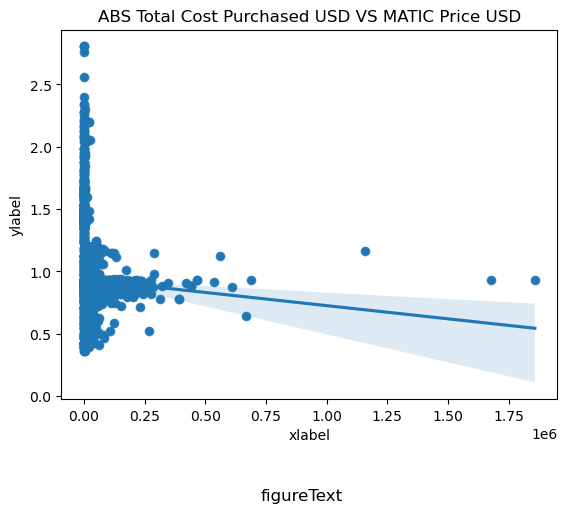

R_value: 0.0022967966417025156
P_value: 0.0022040179169325884


In [242]:
create_scatter_plot(ABStotalCostPurchasedUSD, maticPriceUSD, "ABS Total Cost Purchased USD VS MATIC Price USD", "xlabel", "ylabel", "figureText")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


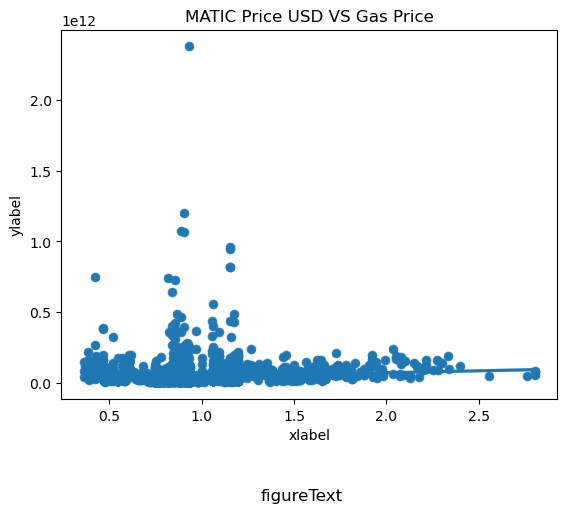

R_value: 0.009277268884602025
P_value: 7.125445612998654e-10


In [243]:
create_scatter_plot(maticPriceUSD, gasPriceUSD, "MATIC Price USD VS Gas Price", "xlabel", "ylabel", "figureText")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


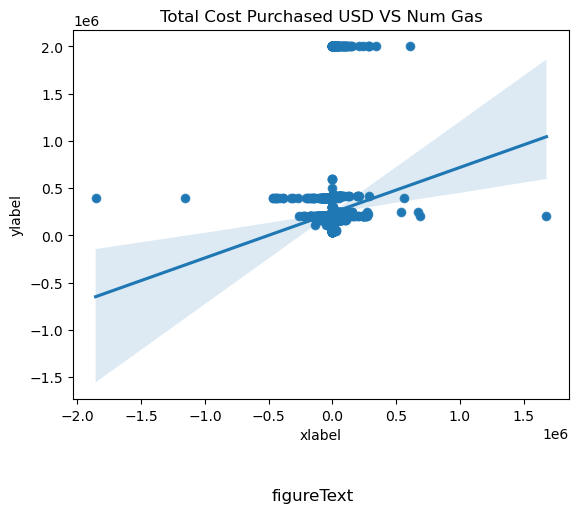

R_value: 0.008624351646169145
P_value: 2.824880854597336e-09


In [244]:
create_scatter_plot(totalCostPurchasedUSD, numGas, "Total Cost Purchased USD VS Num Gas", "xlabel", "ylabel", "figureText")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


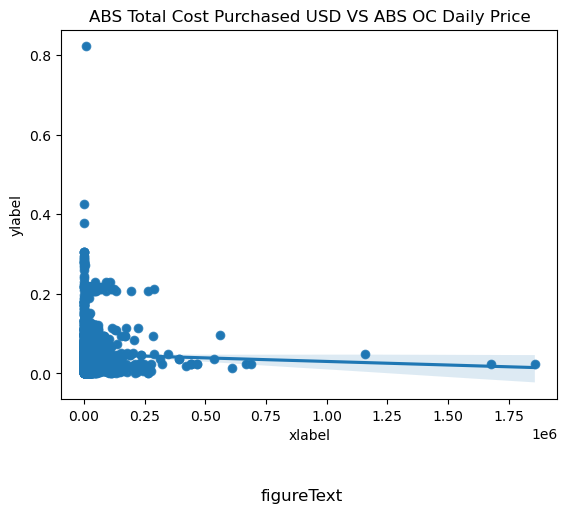

R_value: 0.00032484465754051614
P_value: 0.2498540663595876


In [245]:
create_scatter_plot(ABStotalCostPurchasedUSD, ABSOCdailyPrice, "ABS Total Cost Purchased USD VS ABS OC Daily Price", "xlabel", "ylabel", "figureText")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


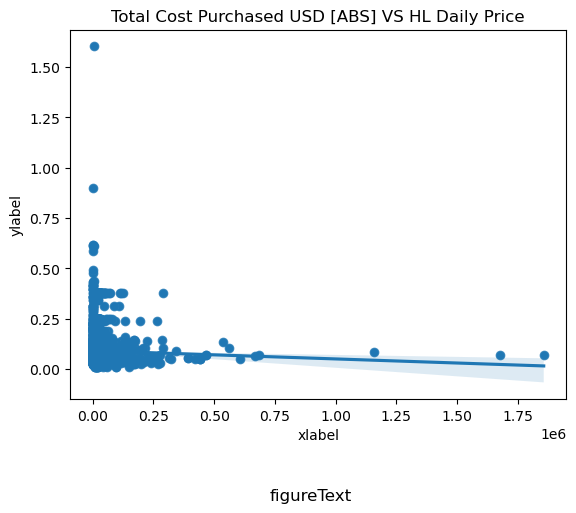

R_value: 0.0008337558513161722
P_value: 0.06522055952615323


In [246]:
create_scatter_plot(ABStotalCostPurchasedUSD, HLdailyPrice, "Total Cost Purchased USD [ABS] VS HL Daily Price", "xlabel", "ylabel", "figureText")

/Users/toddgavin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


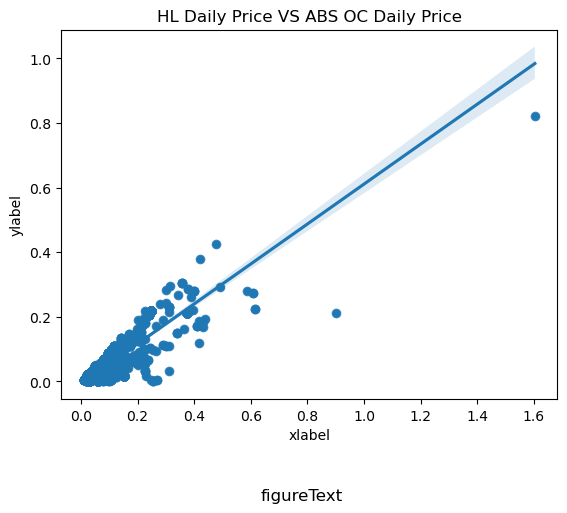

R_value: 0.7638596691131029
P_value: 0.0


In [247]:
create_scatter_plot(HLdailyPrice, ABSOCdailyPrice, "HL Daily Price VS ABS OC Daily Price", "xlabel", "ylabel", "figureText")

timeSeriesTransactionData_df
- Matic Price USD VS Volume
- Matic Price VS ABS Value Moved USD

In [248]:
print(timeSeriesTransactionData_df.columns)

Index(['date', 'numTransactions', 'valueMoved', 'buyNum', 'sellNum',
       'MaticPriceUSD', 'volume'],
      dtype='object')


In [270]:
maticPriceUSD = list(timeSeriesTransactionData_df["MaticPriceUSD"])
maticPriceUSD = [(float(x)*100000000) for x in maticPriceUSD]
volume = list(timeSeriesTransactionData_df["volume"])

ABSValueMovedUSD = list(timeSeriesTransactionData_df["valueMoved"])
ABSValueMovedUSD = [float(abs(x)) for x in ABSValueMovedUSD]

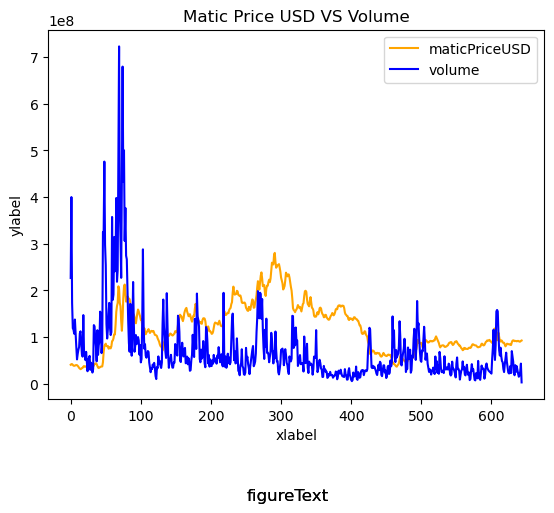

In [271]:
create_line_plot(maticPriceUSD, "maticPriceUSD", volume, "volume", "Matic Price USD VS Volume", "xlabel", "ylabel", "figureText")

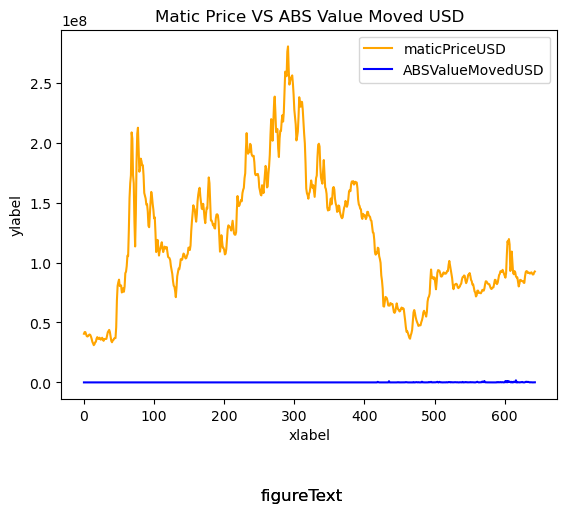

In [272]:
create_line_plot(maticPriceUSD, "maticPriceUSD", ABSValueMovedUSD, "ABSValueMovedUSD", "Matic Price VS ABS Value Moved USD", "xlabel", "ylabel", "figureText")